### Importing necessary libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import sys
import os

# Add project root to Python path
project_root = os.path.join(os.path.dirname(os.getcwd()))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import from src
from src.config import hosp_path, icu_path, label_path

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

In [57]:
base_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed')
features_path = os.path.join(base_path, 'extracted_features.csv')

# Comprehensice EHR Data Descriptive Analysis

## Data Preview

In [58]:
print(f"Loading data from {features_path}")
df = pd.read_csv(features_path)

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Number of patients: {len(df)}")
print(f"Number of features: {len(df.columns)}")

# Preview the data
df.head()

Loading data from c:\Users\Davon\Desktop\University\Semester 8\AI Capstone\Final Project\data\processed\extracted_features.csv
Dataset shape: (16922, 143)
Number of patients: 16922
Number of features: 143


,subject_id_x,hadm_id,stay_id,icu_stay_seq,duration_hours,gender,anchor_age,anchor_year,gender_numeric,admittime,...,alkaline_phosphatase_log,bun_log,has_tachycardia,has_tachypnea,has_fever_or_hypothermia,has_abnormal_wbc,sirs_criteria_count,shock_index,bun_creatinine_ratio,has_hypoxemia
0,103061,205323,320855,1,32.559167,F,53,2156,0,2161-09-30 07:45:00,...,NaN,2.833213,0,0,0,1,1,NaN,14.545455,0
1,115922,202942,317562,1,148.293889,F,80,2128,0,2130-12-17 12:44:00,...,NaN,2.995732,0,0,1,0,1,0.589100,21.111111,0
2,100573,211228,300212,1,236.036944,F,77,2112,0,2114-04-14 22:22:00,...,NaN,NaN,0,0,0,0,0,0.586247,NaN,0
3,113171,201479,309713,1,263.462778,F,80,2155,0,2157-09-23 14:49:00,...,NaN,NaN,0,0,0,0,0,NaN,NaN,0
4,111478,218479,302511,1,122.400556,M,81,2141,1,2142-10-04 20:17:00,...,NaN,3.433987,1,1,0,1,3,0.948108,21.428571,0


## Checking Missing Values

In [59]:
# Basic data types and null values
print("Data Types and Null Values:")
df_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null Percentage': round(df.isnull().sum() / len(df) * 100, 2)
})

df_info.sort_values('Null Percentage', ascending=False).head(20)

Data Types and Null Values:


,Data Type,Non-Null Count,Null Count,Null Percentage
bmi,float64,0,16922,100.00
bilirubin_delta,float64,3811,13111,77.48
bilirubin_mean,float64,3813,13109,77.47
bilirubin_log,float64,3813,13109,77.47
bilirubin_max,float64,3813,13109,77.47
alkaline_phosphatase_max,float64,3854,13068,77.22
alkaline_phosphatase_delta,float64,3854,13068,77.22
alkaline_phosphatase_mean,float64,3854,13068,77.22
alkaline_phosphatase_log,float64,3854,13068,77.22
map_min,float64,4950,11972,70.75


<Figure size 12000x6000 with 0 Axes>

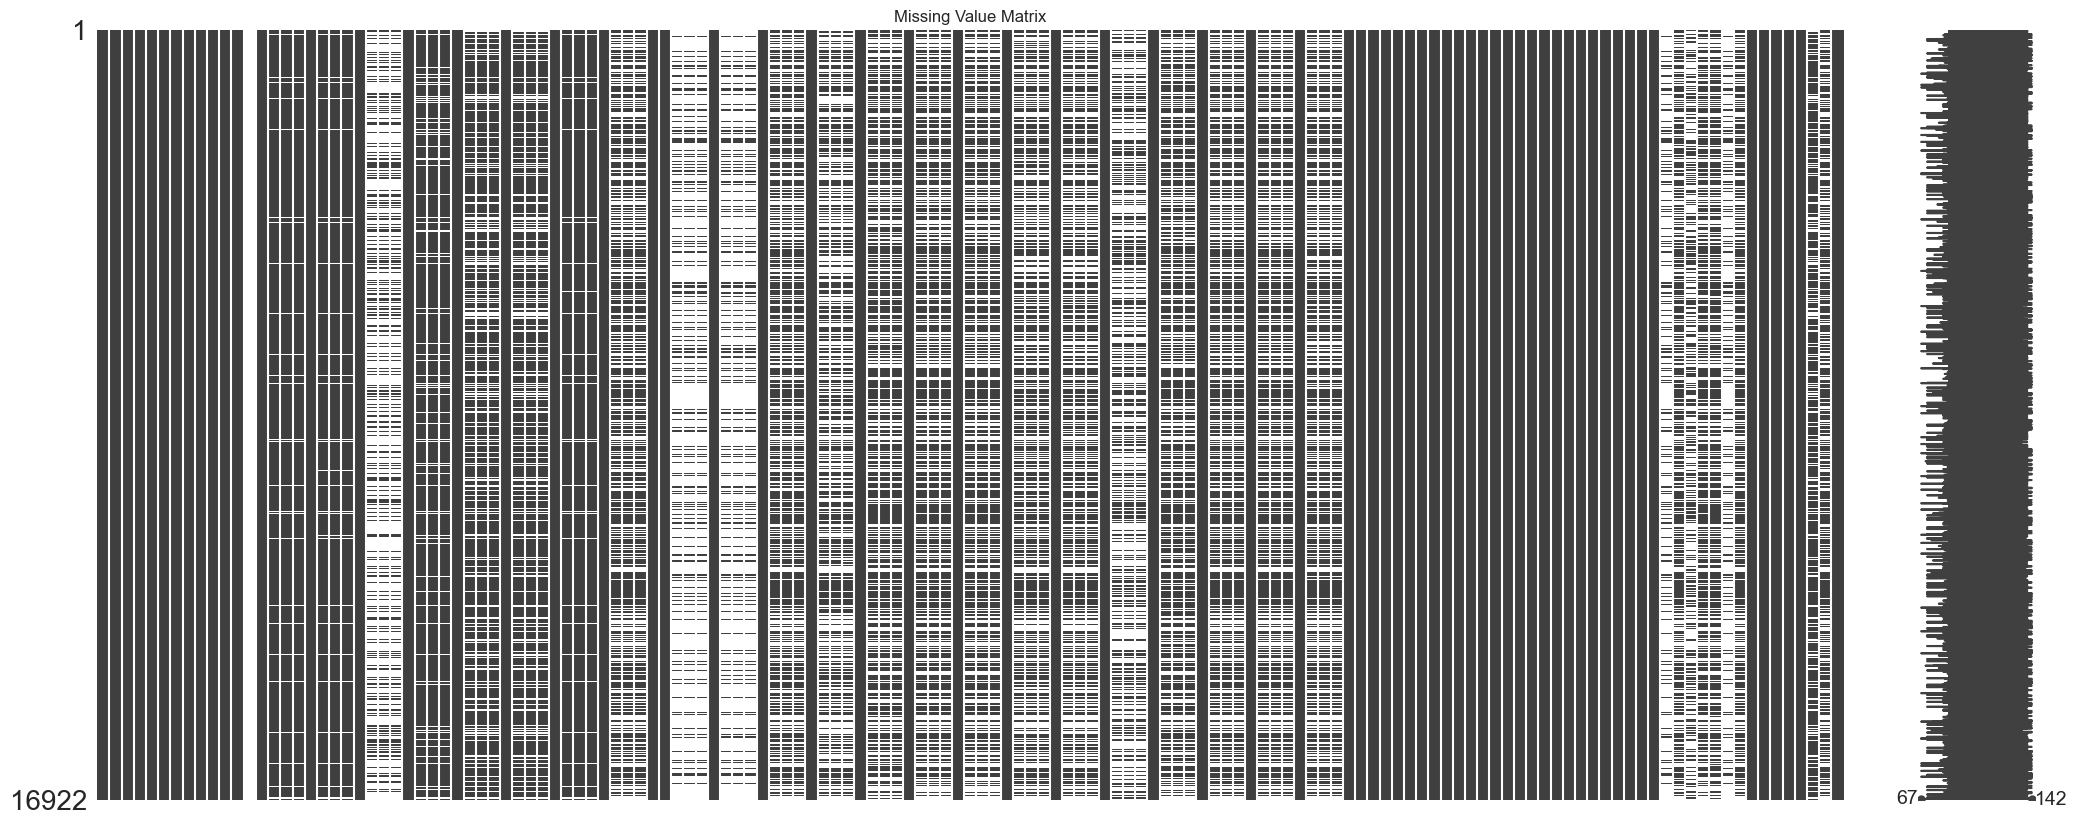

<Figure size 12000x10000 with 0 Axes>

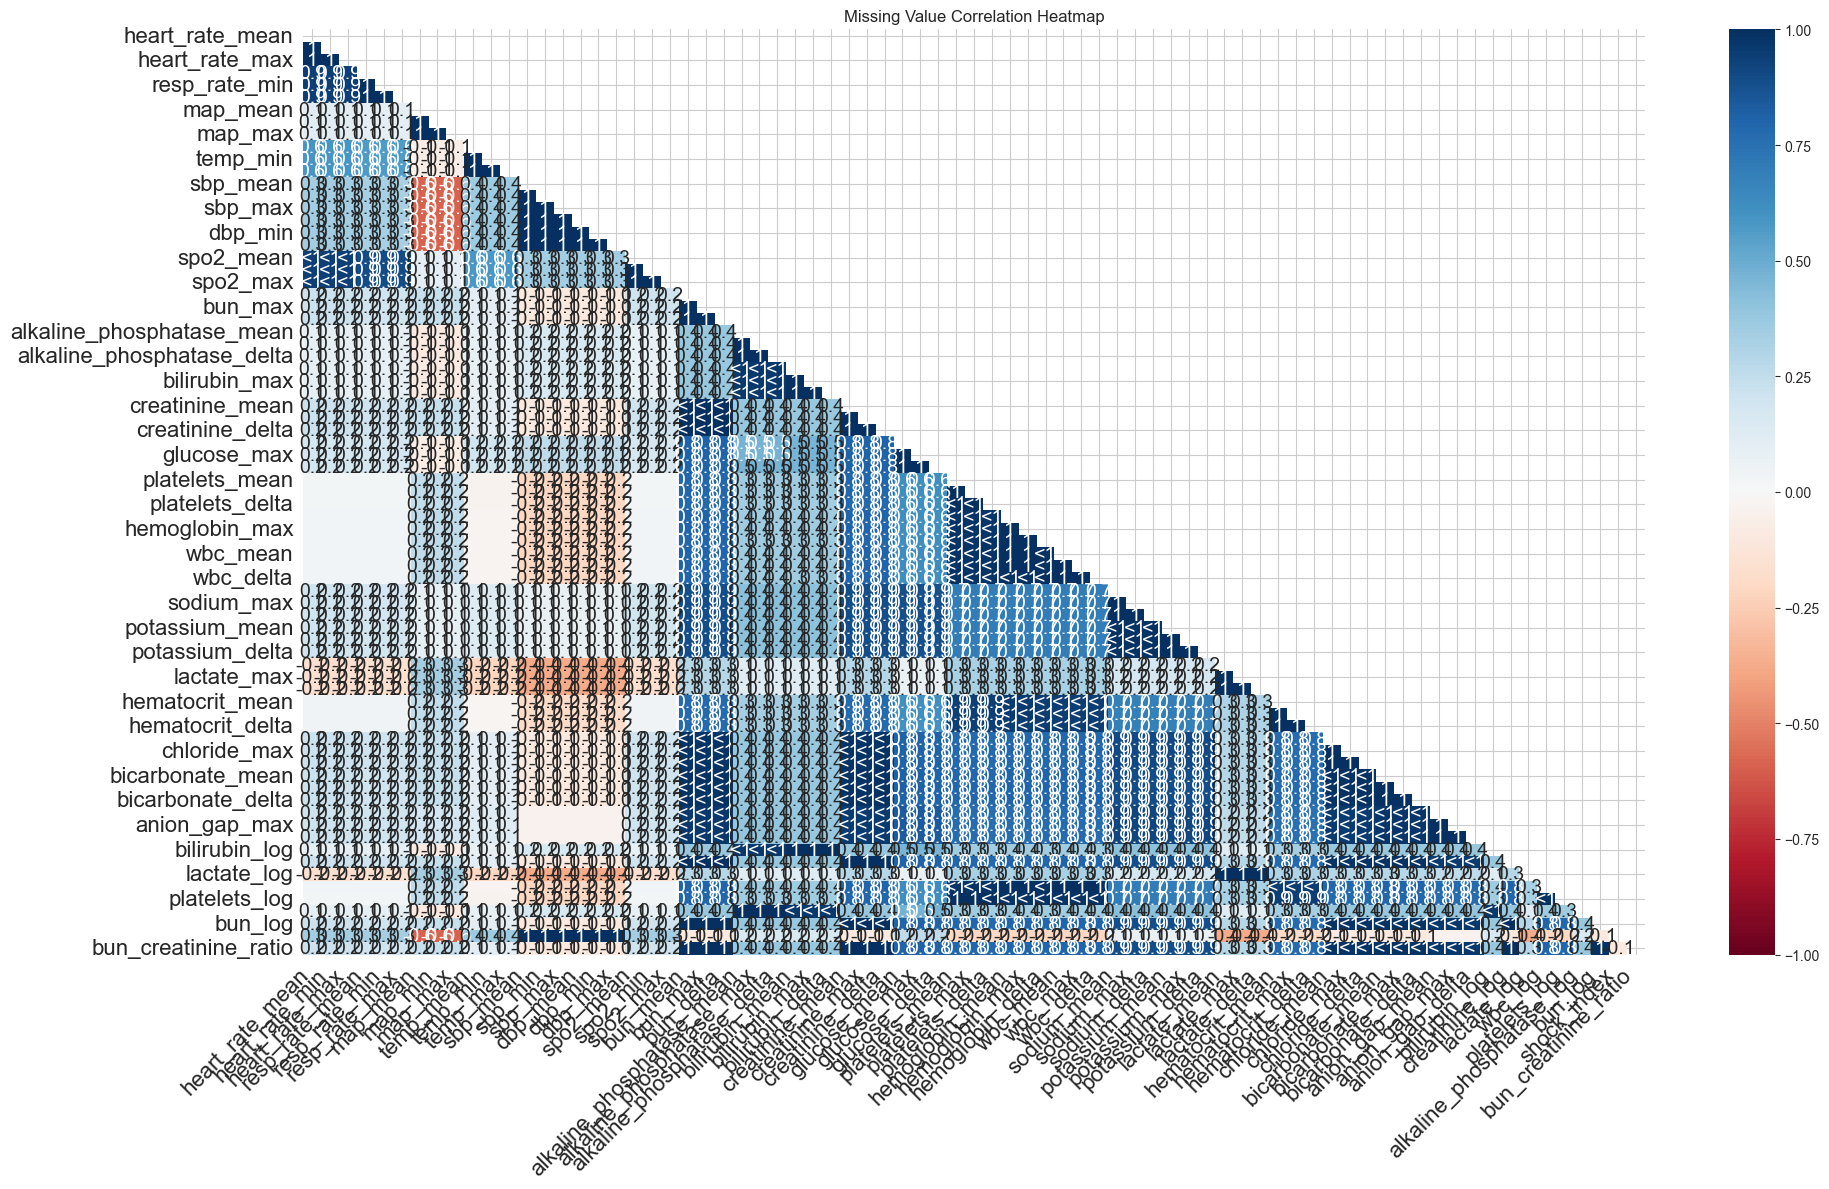

In [60]:
# Visualize missing values
plt.figure(figsize=(120, 60))
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()

# Missing value correlation
plt.figure(figsize=(120, 100))
msno.heatmap(df)
plt.title("Missing Value Correlation Heatmap")
plt.tight_layout()
plt.show()

## Separating Numeric and Categorical Features

In [61]:
# Separate numeric and categorical features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Number of numeric features: {len(numeric_features)}")
print(f"Number of categorical features: {len(categorical_features)}")

# Remove ID columns from analysis if present
id_cols = [col for col in df.columns if 'id' in col.lower()]
numeric_features = [col for col in numeric_features if col not in id_cols]
categorical_features = [col for col in categorical_features if col not in id_cols]

print("\nNumeric features (sample):", numeric_features[:10])
print("\nCategorical features:", categorical_features)

Number of numeric features: 141
Number of categorical features: 2

Numeric features (sample): ['icu_stay_seq', 'duration_hours', 'anchor_age', 'anchor_year', 'gender_numeric', 'admittime_year', 'age', 'bmi', 'bmi_measured', 'heart_rate_mean']

Categorical features: ['gender', 'admittime']


### Numeric Values Analysis

In [62]:
# Descriptive statistics for numeric variables
desc_stats = df[numeric_features].describe().T
desc_stats['missing_pct'] = df[numeric_features].isnull().sum() * 100 / len(df)
desc_stats['cv'] = desc_stats['std'] / desc_stats['mean']  # Coefficient of variation

# Add skewness and kurtosis
desc_stats['skewness'] = df[numeric_features].skew()
desc_stats['kurtosis'] = df[numeric_features].kurt()

# Sort by missing percentage
desc_stats.sort_values('missing_pct', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max,missing_pct,cv,skewness,kurtosis
bmi,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN
bilirubin_delta,3811.0,0.005091,0.190124,-5.300000,0.000000,0.000000,0.000000,4.800000,77.479021,37.348675,4.537115,393.323010
bilirubin_max,3813.0,1.522135,3.309148,0.100000,0.400000,0.600000,1.200000,30.000000,77.467202,2.174018,5.897875,40.251810
bilirubin_mean,3813.0,1.512409,3.296276,0.100000,0.400000,0.600000,1.200000,30.000000,77.467202,2.179487,5.938014,40.811227
bilirubin_log,3813.0,0.670156,0.552960,0.095310,0.336472,0.470004,0.788457,3.433987,77.467202,0.825123,2.379237,6.742642
alkaline_phosphatase_max,3854.0,110.178775,103.512245,5.000000,60.000000,80.000000,118.000000,1000.000000,77.224914,0.939494,4.288254,24.859331
alkaline_phosphatase_delta,3854.0,-0.183186,5.369906,-163.000000,0.000000,0.000000,0.000000,126.000000,77.224914,-29.313904,-5.537017,360.451291
alkaline_phosphatase_mean,3854.0,109.842458,103.204175,5.000000,60.000000,80.000000,117.000000,1000.000000,77.224914,0.939565,4.291778,24.927252
alkaline_phosphatase_log,3854.0,4.493778,0.586417,1.791759,4.110874,4.394449,4.770685,6.908755,77.224914,0.130495,1.001033,1.851218
map_min,4950.0,66.588687,17.072419,20.000000,59.000000,67.000000,76.000000,200.000000,70.748139,0.256386,-0.306538,3.179669


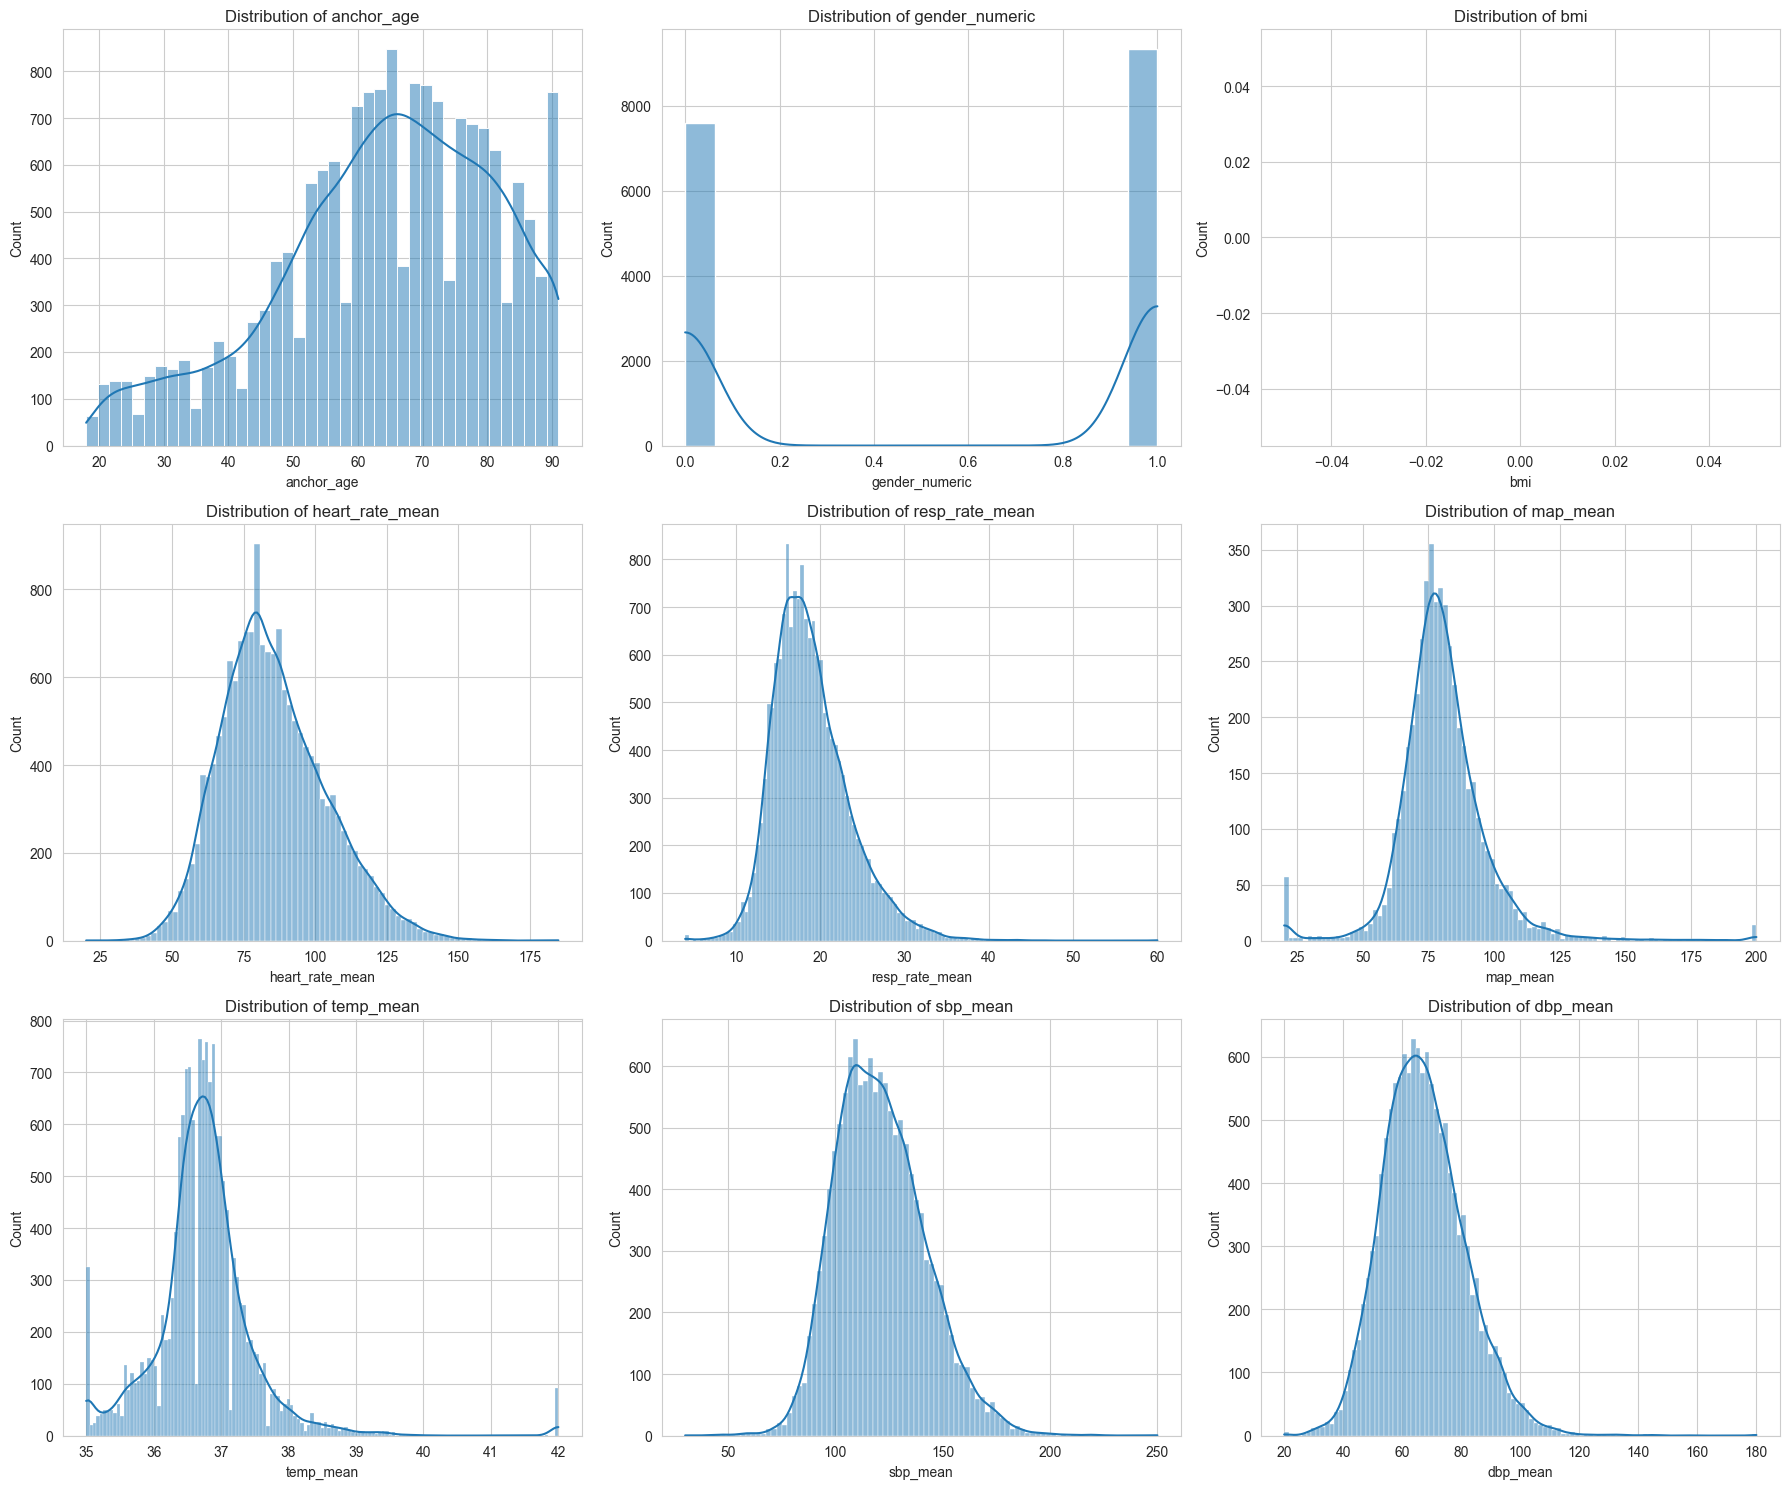

In [63]:
# Function to plot histograms for numeric variables
def plot_histograms(dataframe, features, rows=3, cols=3):
    """Plot histograms for selected numeric features"""
    fig = plt.figure(figsize=(18, 5*rows))
    
    for i, feature in enumerate(features):
        if i >= rows*cols:
            break
            
        ax = fig.add_subplot(rows, cols, i+1)
        sns.histplot(dataframe[feature].dropna(), kde=True, ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Plot histograms for key features
key_features = ['anchor_age', 'gender_numeric', 'bmi']
key_features.extend([col for col in numeric_features if '_mean' in col][:6])
plot_histograms(df, key_features)

### Boxplots for Key Vital Signs and Lab Values

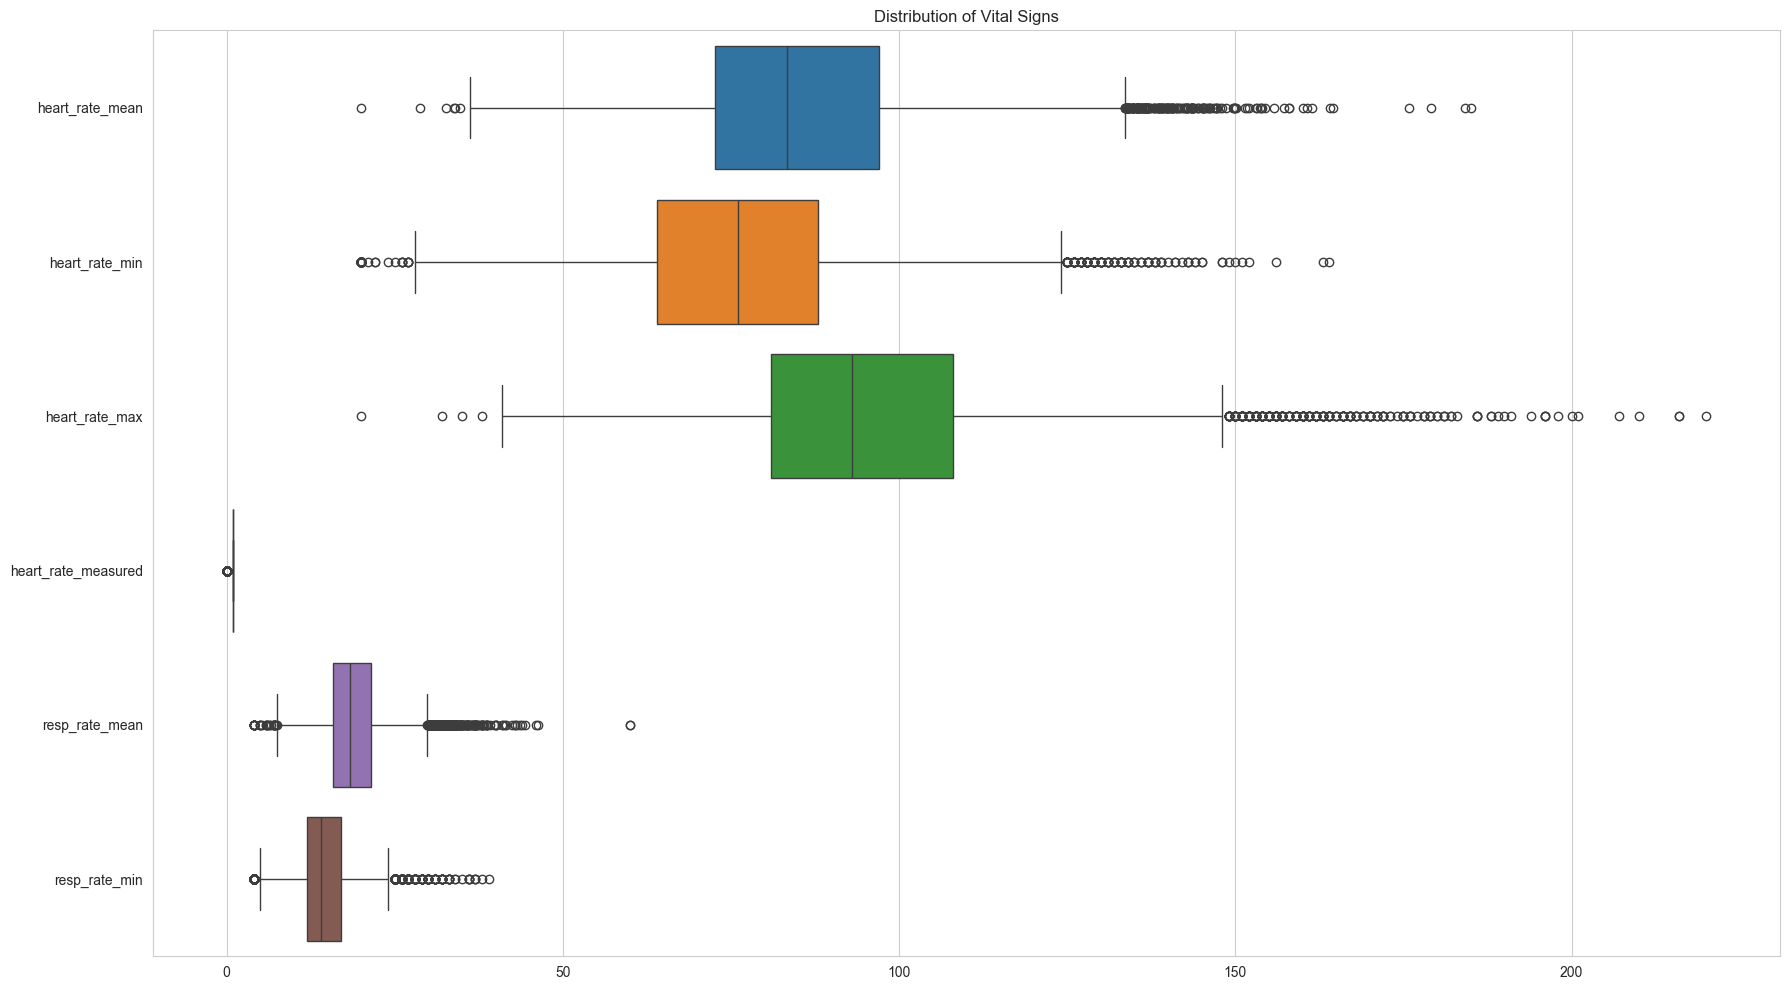

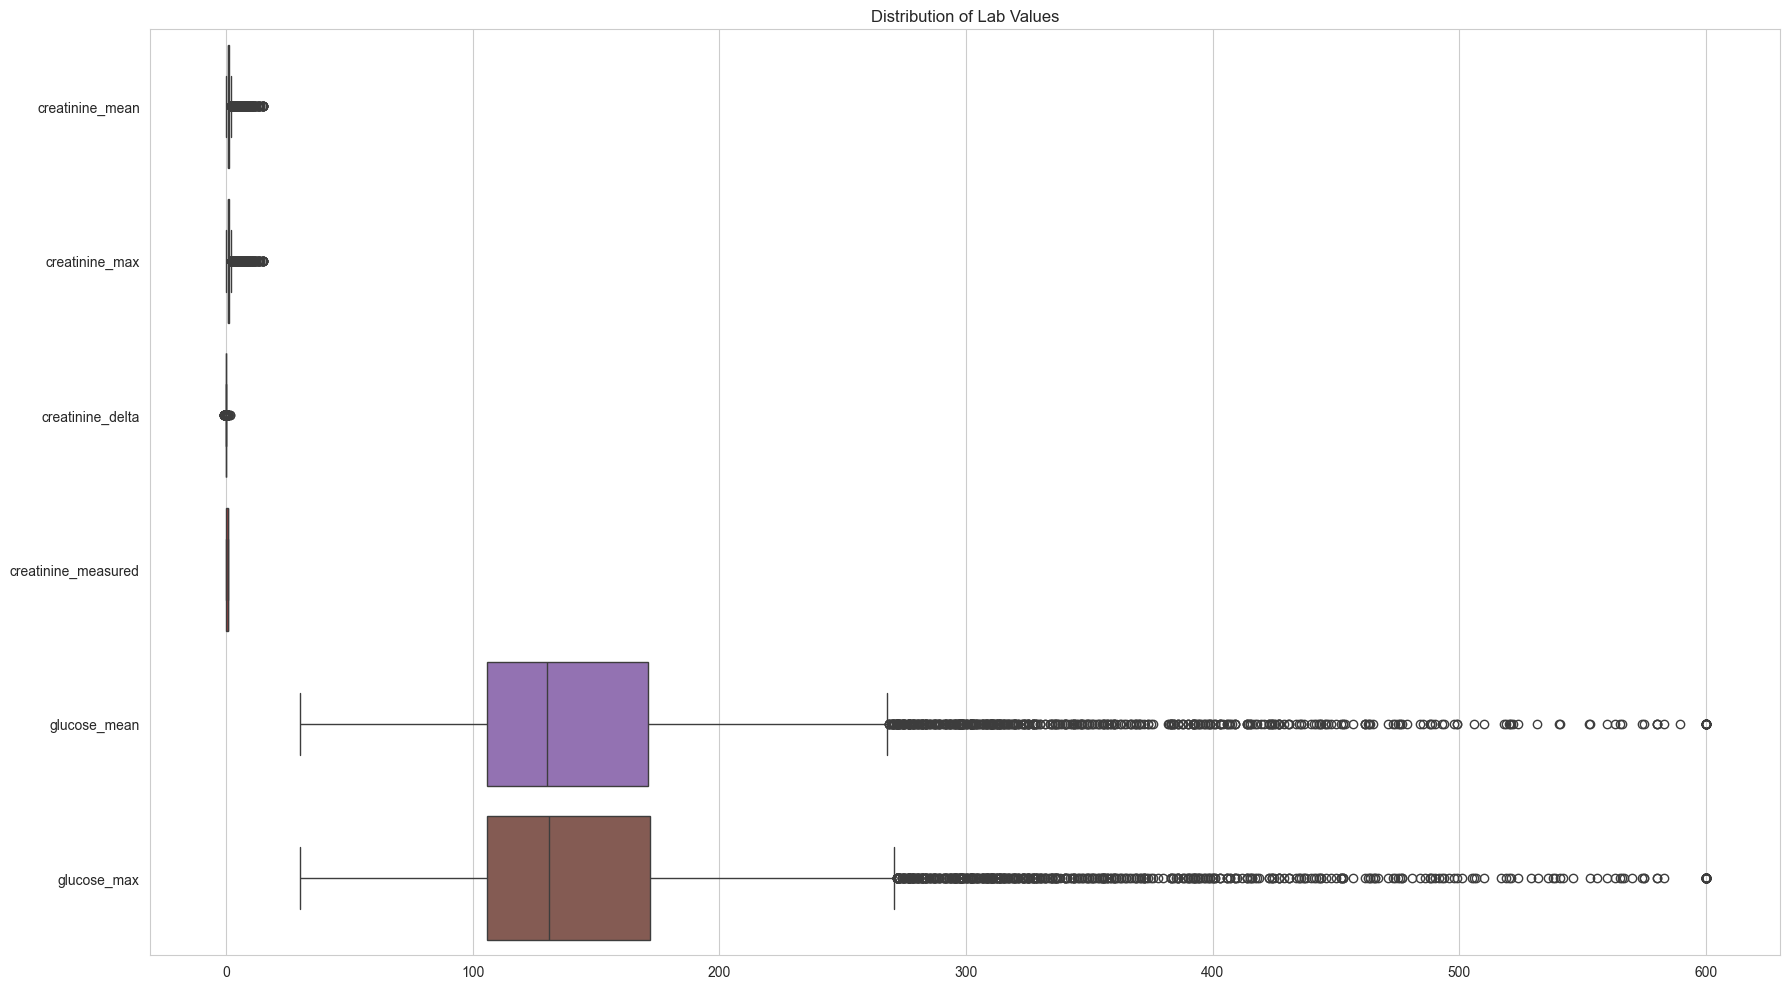

In [64]:
# Plot boxplots for key vital signs and lab values
vital_features = [col for col in numeric_features if any(x in col for x in ['heart_rate', 'resp_rate', 'map', 'sbp', 'dbp', 'spo2'])]
lab_features = [col for col in numeric_features if any(x in col for x in ['glucose', 'creatinine', 'sodium', 'potassium', 'hemoglobin', 'wbc'])]

plt.figure(figsize=(18, 10))
sns.boxplot(data=df[vital_features[:6]], orient='h')
plt.title("Distribution of Vital Signs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 10))
sns.boxplot(data=df[lab_features[:6]], orient='h')
plt.title("Distribution of Lab Values")
plt.tight_layout()
plt.show()

## Identify Outliers

Features with most outliers:
alkaline_phosphatase_measured    3854
bilirubin_measured               3838
dbp_measured                     3544
sbp_measured                     3543
hematocrit_delta                 2739
lactate_delta                    2617
platelets_delta                  2468
hemoglobin_delta                 2396
wbc_delta                        2367
has_fever_or_hypothermia         2353
temp_min                         2060
duration_hours                   1852
temp_max                         1750
temp_measured                    1351
temp_mean                        1259
creatinine_max                   1019
potassium_delta                  1012
creatinine_mean                  1010
glucose_delta                     954
bun_max                           941
dtype: int64


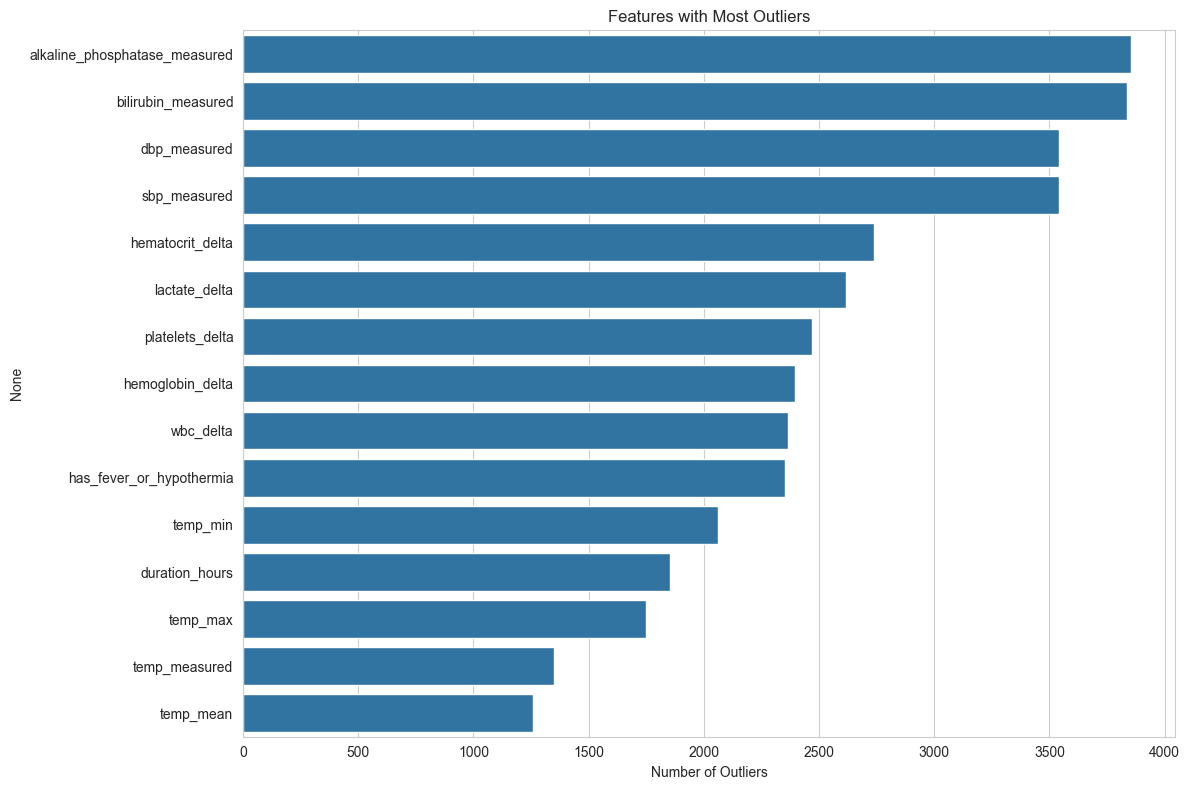

In [65]:
# Identify outliers using IQR method
def detect_outliers(df, features):
    """Detect outliers using IQR method and return counts"""
    outliers_count = {}
    
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_count[col] = len(outliers)
    
    return pd.Series(outliers_count)

# Get outlier counts for numeric features
numeric_no_id = [col for col in numeric_features if not ('id' in col.lower() or 'count' in col.lower())]
outliers = detect_outliers(df, numeric_no_id)
outliers = outliers.sort_values(ascending=False)

print("Features with most outliers:")
print(outliers.head(20))

# Visualize top features with outliers
plt.figure(figsize=(12, 8))
sns.barplot(x=outliers.head(15).values, y=outliers.head(15).index)
plt.title("Features with Most Outliers")
plt.xlabel("Number of Outliers")
plt.tight_layout()
plt.show()

## Correlation Analysis

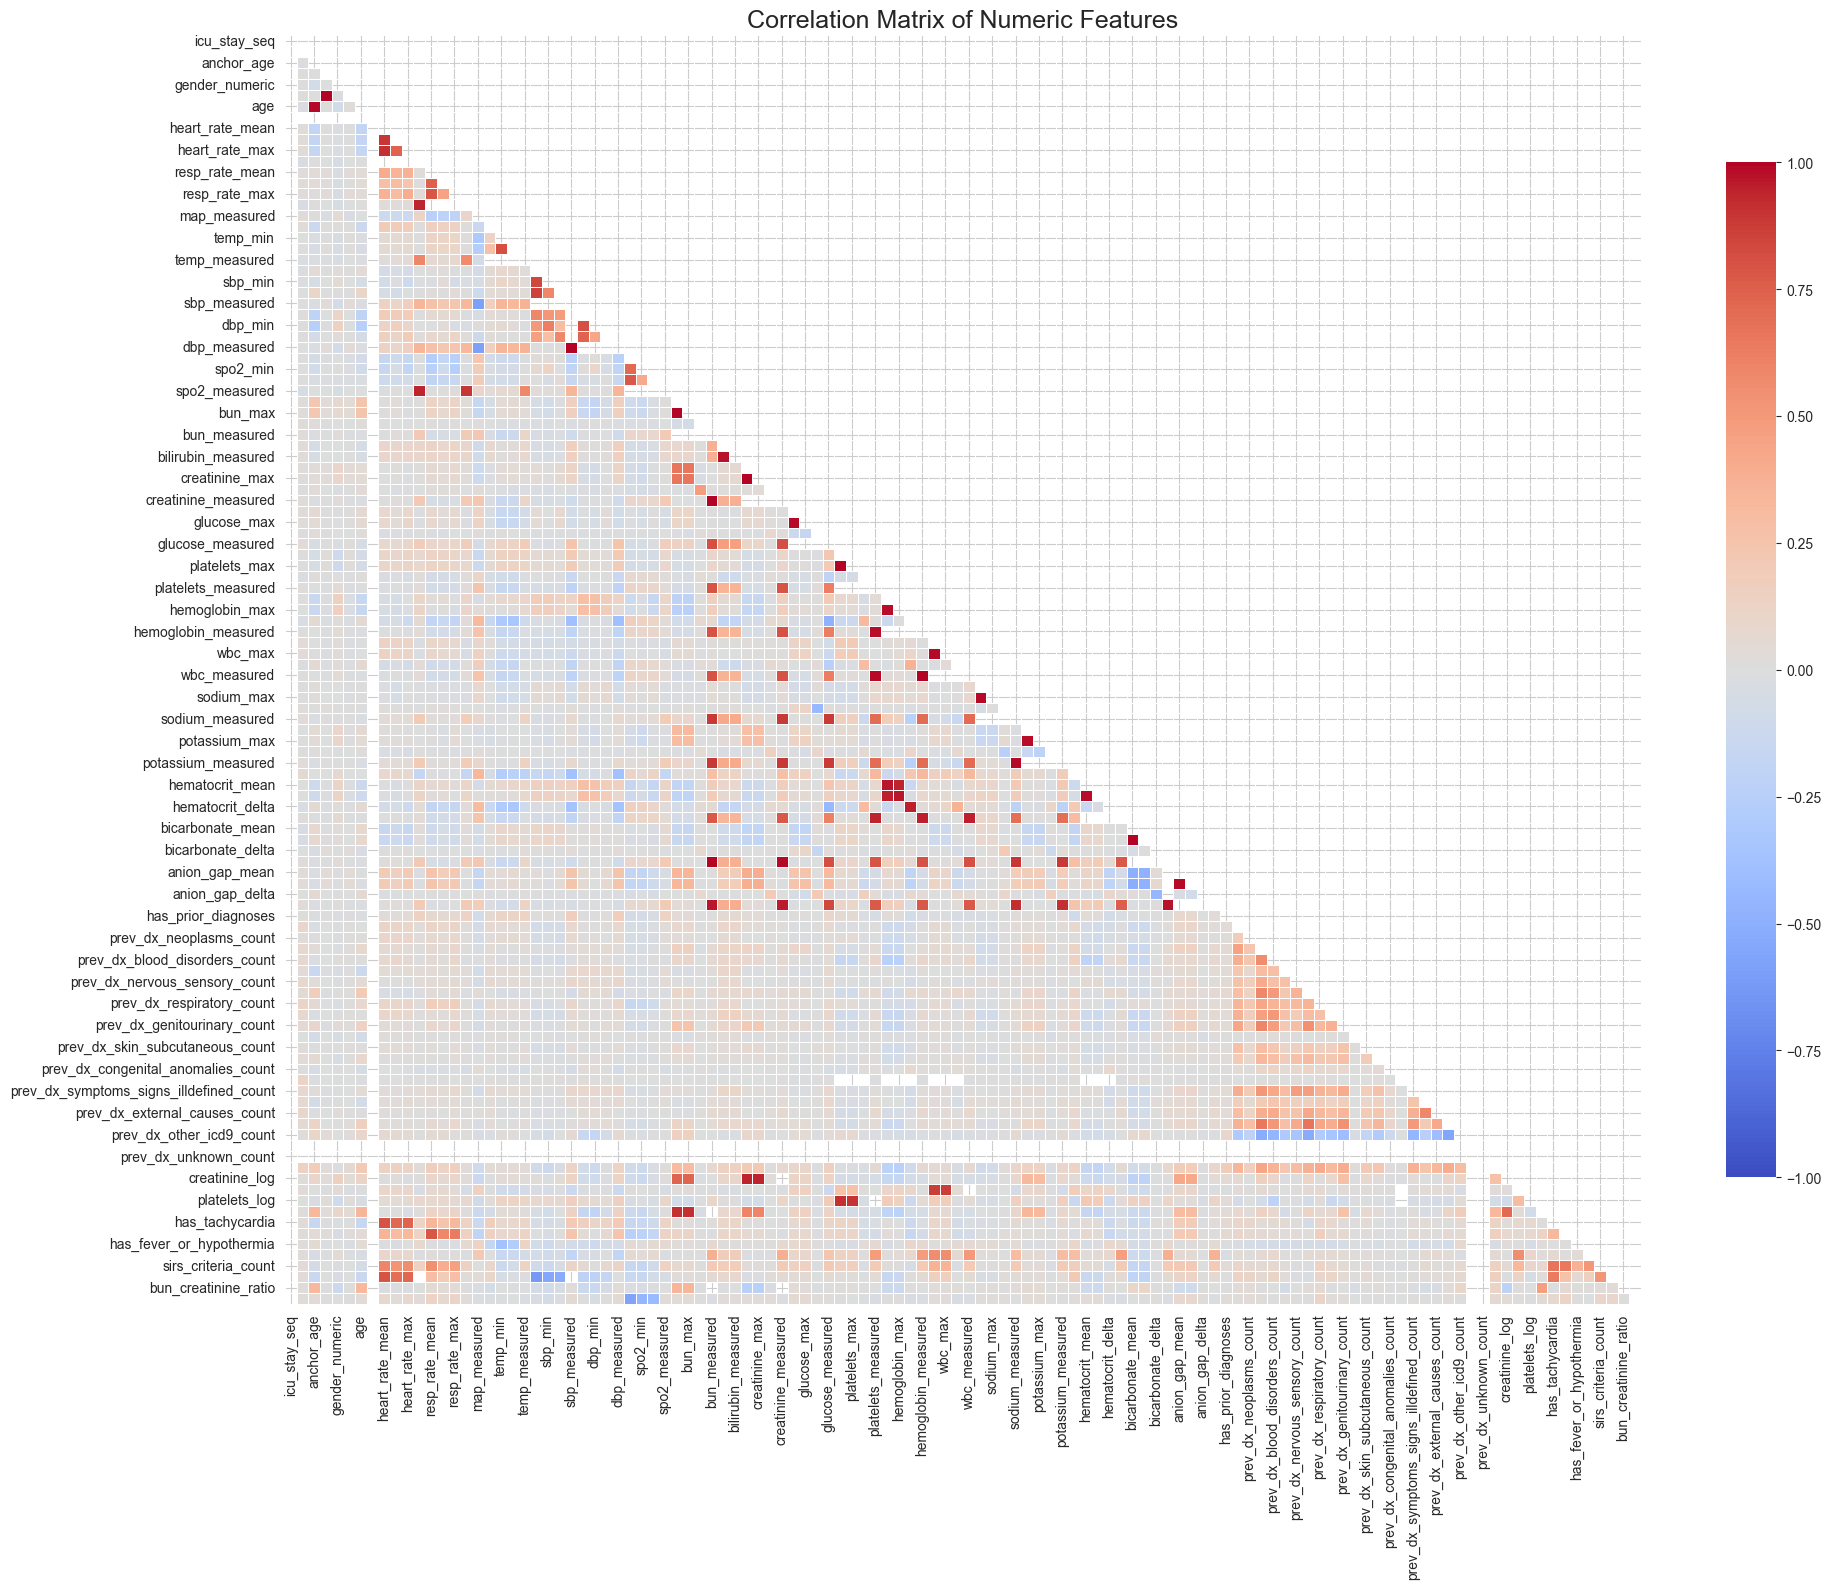

,Feature 1,Feature 2,Correlation
19,sbp_measured,dbp_measured,0.999822
40,creatinine_mean,creatinine_max,0.999697
24,bun_mean,bun_max,0.999405
57,platelets_mean,platelets_max,0.995997
72,hemoglobin_measured,wbc_measured,0.995648
...,...,...,...
82,wbc_measured,potassium_measured,0.704454
81,wbc_measured,sodium_measured,0.704114
74,hemoglobin_measured,potassium_measured,0.702888
73,hemoglobin_measured,sodium_measured,0.702558


In [66]:
# Correlation analysis for numeric variables
# Use only features with less than 50% missing values
low_missing_features = [col for col in numeric_features 
                        if df[col].isnull().mean() < 0.5 and 'id' not in col.lower()]

# Calculate correlation matrix
corr_matrix = df[low_missing_features].corr()

# Plot correlation matrix
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Features', fontsize=18)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Find most highly correlated pairs
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:  # Threshold of 0.7
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display most highly correlated pairs
corr_pairs_df = pd.DataFrame(corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
corr_pairs_df = corr_pairs_df.sort_values('Correlation', key=abs, ascending=False)
corr_pairs_df

## Categorical Features (Age)

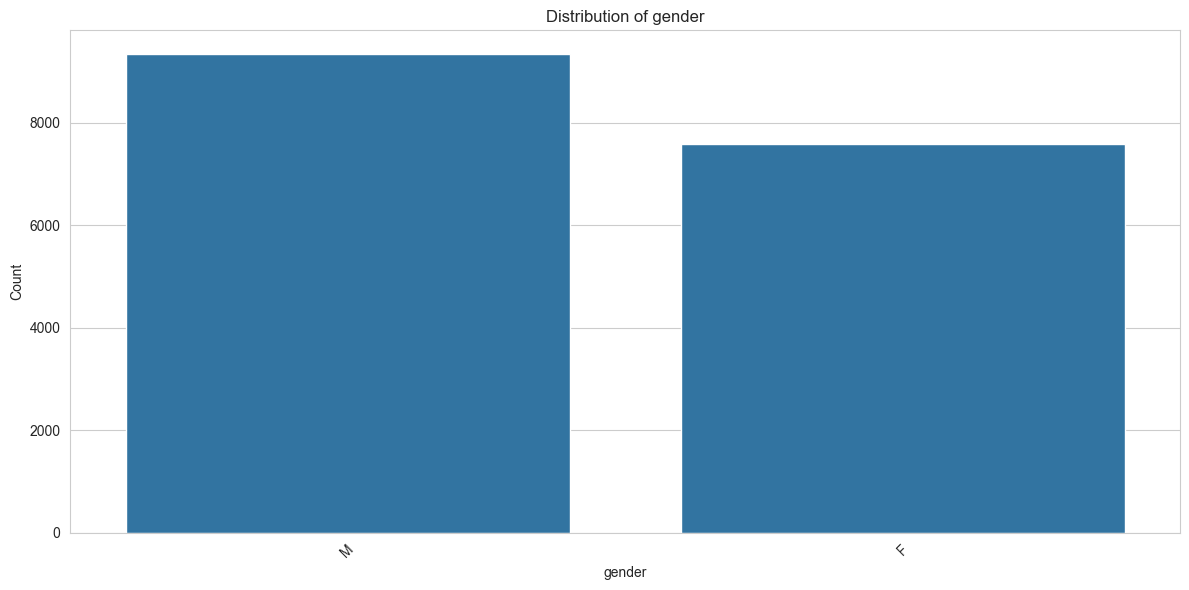


Frequency Table for gender:
        Count  Percentage
gender                   
M        9335   55.164874
F        7587   44.835126


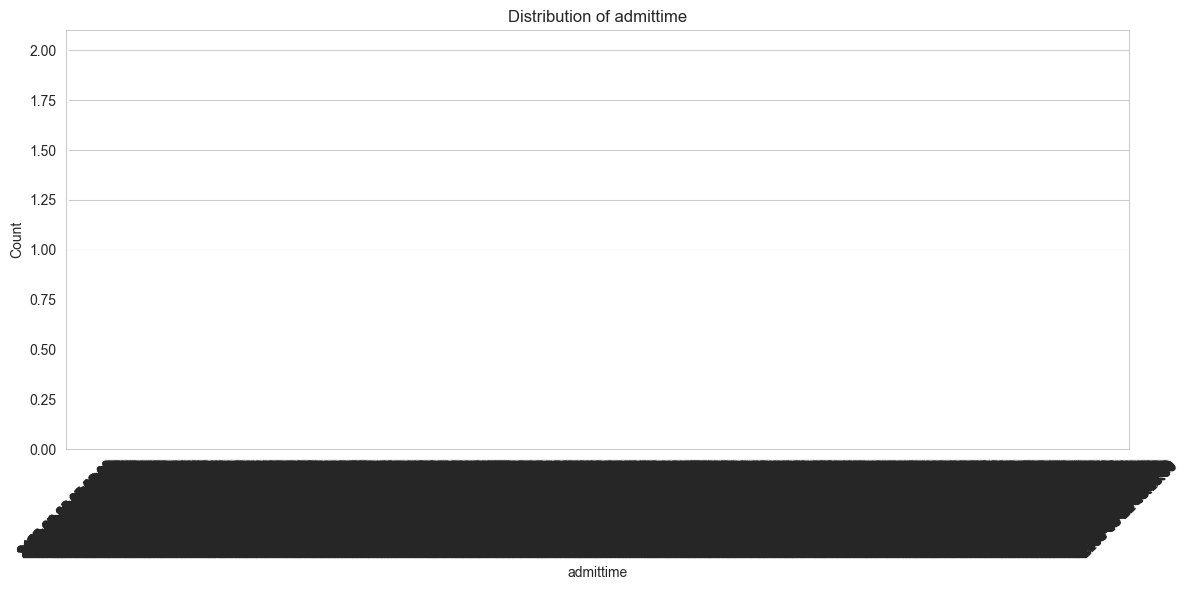


Frequency Table for admittime:
                     Count  Percentage
admittime                             
2152-11-25 00:00:00      2    0.011819
2175-10-30 17:44:00      2    0.011819
2134-12-31 20:32:00      2    0.011819
2185-02-15 07:15:00      2    0.011819
2171-09-26 00:00:00      2    0.011819
...                    ...         ...
2149-12-27 22:57:00      1    0.005909
2175-10-08 19:37:00      1    0.005909
2138-10-25 18:36:00      1    0.005909
2188-01-28 16:12:00      1    0.005909
2177-10-20 23:15:00      1    0.005909

[16910 rows x 2 columns]


In [67]:
# Analysis of categorical variables
if categorical_features:
    for cat_feature in categorical_features:
        plt.figure(figsize=(12, 6))
        value_counts = df[cat_feature].value_counts().sort_values(ascending=False)
        
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'Distribution of {cat_feature}')
        plt.xlabel(cat_feature)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print frequency table
        freq_table = pd.DataFrame({
            'Count': df[cat_feature].value_counts(),
            'Percentage': df[cat_feature].value_counts(normalize=True) * 100
        })
        print(f"\nFrequency Table for {cat_feature}:")
        print(freq_table)
else:
    print("No categorical features to analyze")

## PCA for Numeric Features

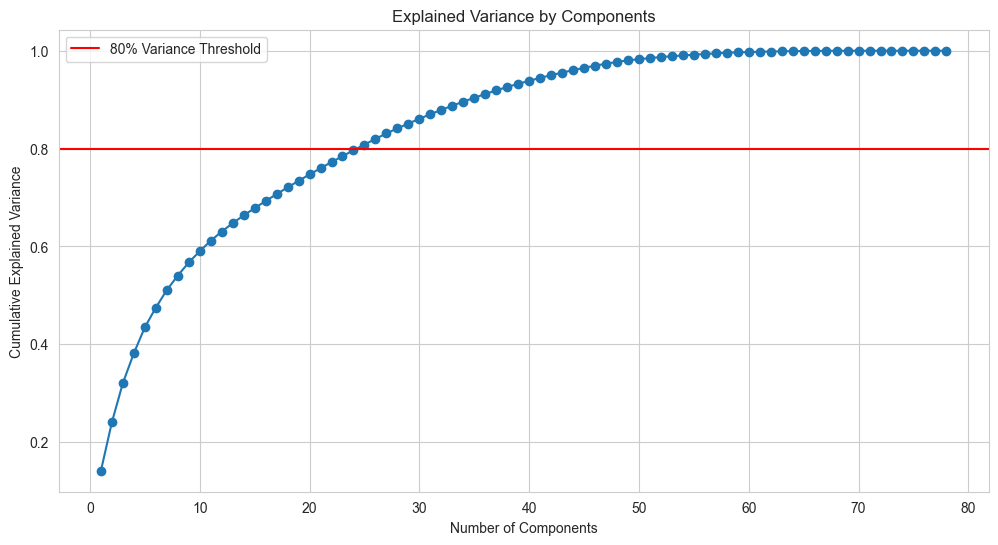

Number of components needed to explain 80% of variance: 25

Top 10 contributing features to PC1:
bicarbonate_measured    0.291041
bun_measured            0.290801
creatinine_measured     0.290408
anion_gap_measured      0.288080
sodium_measured         0.273199
potassium_measured      0.272964
wbc_measured            0.272837
hemoglobin_measured     0.272329
platelets_measured      0.270056
hematocrit_measured     0.265054
dtype: float64

Top 10 contributing features to PC2:
resp_rate_mean                         0.210670
heart_rate_mean                        0.205200
prev_dx_endocrine_metabolic_count      0.201539
resp_rate_max                          0.197156
heart_rate_max                         0.194743
has_tachypnea                          0.194497
has_tachycardia                        0.193320
prev_dx_factors_health_status_count    0.191639
prev_dx_respiratory_count              0.187320
heart_rate_min                         0.184625
dtype: float64


In [68]:
# Principal Component Analysis for dimensionality reduction
# Select numeric features with less than 30% missing values
pca_features = [col for col in numeric_features 
                if df[col].isnull().mean() < 0.3 and 'id' not in col.lower()]

# Fill missing values with median for PCA
df_pca = df[pca_features].fillna(df[pca_features].median())

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

# Plot explained variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.8, color='r', linestyle='-', label='80% Variance Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Calculate number of components for 80% variance
n_components_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0] + 1
print(f"Number of components needed to explain 80% of variance: {n_components_80}")

# Show top feature contributions to first two principal components
pca_components = pd.DataFrame(
    abs(pca.components_[:2, :]),
    columns=pca_features
)

print("\nTop 10 contributing features to PC1:")
pc1_contributions = pd.Series(abs(pca.components_[0]), index=pca_features).sort_values(ascending=False)
print(pc1_contributions.head(10))

print("\nTop 10 contributing features to PC2:")
pc2_contributions = pd.Series(abs(pca.components_[1]), index=pca_features).sort_values(ascending=False)
print(pc2_contributions.head(10))

## Patient Cohort Characteristics Summary

In [69]:
# Patient cohort characteristics - summary table
# Create a table of key clinical indicators

# Function to calculate normal ranges
def in_normal_range(series, low, high):
    """Calculate percentage of values within normal range"""
    if series.isnull().all():
        return np.nan
    return ((series >= low) & (series <= high)).mean() * 100

# Define key metrics and their normal ranges
metrics = {
    'heart_rate_mean': [60, 100],  # bpm
    'resp_rate_mean': [12, 20],    # breaths per minute
    'sbp_mean': [90, 140],         # mmHg
    'dbp_mean': [60, 90],          # mmHg
    'spo2_mean': [95, 100],        # %
    'temp_mean': [36.5, 37.5],     # Celsius
    'glucose_mean': [70, 140],     # mg/dL
    'creatinine_mean': [0.7, 1.3], # mg/dL
    'sodium_mean': [135, 145],     # mEq/L
    'potassium_mean': [3.5, 5.0],  # mEq/L
    'bmi': [18.5, 25],             # kg/m^2
}

# Collect rows in a list
rows = []
for metric, normal_range in metrics.items():
    if metric in df.columns:
        row = {
            'Metric': metric,
            'Mean': df[metric].mean(),
            'Median': df[metric].median(),
            'Within Normal Range (%)': in_normal_range(df[metric], normal_range[0], normal_range[1]),
            'Missing (%)': df[metric].isnull().mean() * 100
        }
        rows.append(row)

clinical_summary = pd.DataFrame(rows, columns=['Metric', 'Mean', 'Median', 'Within Normal Range (%)', 'Missing (%)'])
clinical_summary.sort_values('Within Normal Range (%)', ascending=True)

,Metric,Mean,Median,Within Normal Range (%),Missing (%)
6,glucose_mean,149.799855,130.000000,31.089706,45.059686
7,creatinine_mean,1.278464,0.900000,37.921050,35.279518
8,sodium_mean,138.357988,139.000000,47.494386,39.032029
9,potassium_mean,4.181501,4.100000,47.908049,38.831107
3,dbp_mean,67.356774,66.250000,49.013119,20.943151
5,temp_mean,36.755312,36.722222,56.110389,7.983690
1,resp_rate_mean,18.974469,18.279175,60.849781,3.486586
2,sbp_mean,121.139396,119.290102,61.458456,20.937241
0,heart_rate_mean,85.625499,83.392857,71.079069,3.102470
4,spo2_mean,97.207424,97.666667,80.398298,3.433400


## Group Analysis

Mean                  Median                Std Dev  \
Gender               Female        Male      Female        Male     Female   
Metric                                                                       
age               68.097403   65.262667   71.000000   67.000000  17.047927   
creatinine_mean    1.135410    1.390037    0.800000    1.000000   1.161440   
dbp_mean          65.735651   68.781632   64.504989   67.805000  14.103267   
glucose_mean     150.583548  149.132733  132.000000  129.000000  70.679997   
heart_rate_mean   86.187100   85.161647   84.079755   82.801563  18.391194   
hemoglobin_mean   10.369532   11.034578   10.300000   11.000000   1.999911   
sbp_mean         120.675410  121.547152  118.494809  120.000000  21.151156   

                            
Gender                Male  
Metric                      
age              16.427797  
creatinine_mean   1.356159  
dbp_mean         13.951651  
glucose_mean     72.049815  
heart_rate_mean  18.432821  
hemoglobin_mean   2.272296  
sbp_mean         20.774520

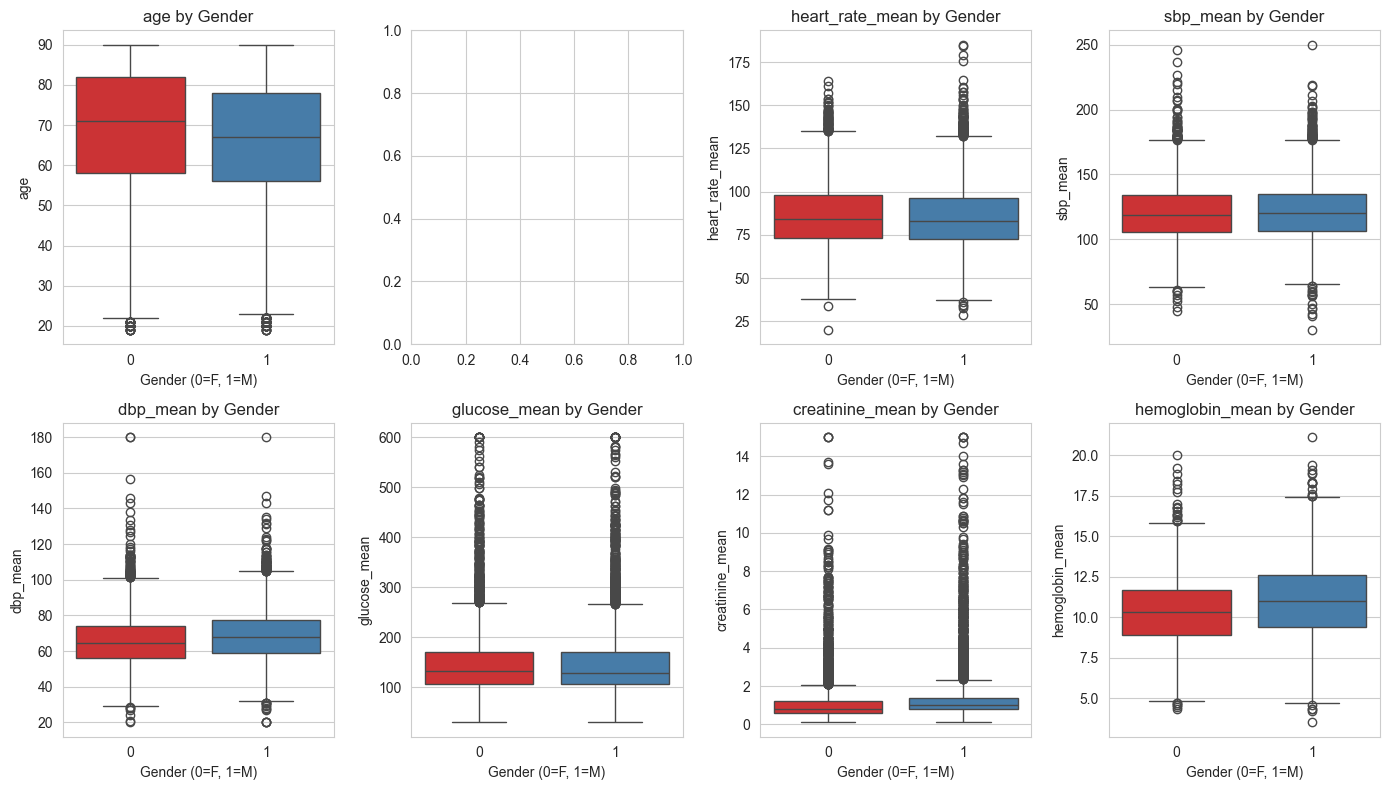

In [71]:
# Group analysis - compare different patient groups if possible
if 'gender_numeric' in df.columns:
    gender_groups = {0: 'Female', 1: 'Male'}
    
    # Compare key metrics by gender
    key_metrics = ['age', 'bmi', 'heart_rate_mean', 'sbp_mean', 'dbp_mean', 
                  'glucose_mean', 'creatinine_mean', 'hemoglobin_mean']
    key_metrics = [m for m in key_metrics if m in df.columns]
    
    # Collect rows in a list
    rows = []
    for metric in key_metrics:
        for gender_code, gender_name in gender_groups.items():
            # Handle missing columns gracefully
            if metric in df.columns:
                row = {
                    'Metric': metric,
                    'Gender': gender_name,
                    'Mean': df[df['gender_numeric'] == gender_code][metric].mean(),
                    'Median': df[df['gender_numeric'] == gender_code][metric].median(),
                    'Std Dev': df[df['gender_numeric'] == gender_code][metric].std(),
                }
                rows.append(row)
    
    # Create DataFrame from rows
    comparison_table = pd.DataFrame(rows)
    
    # Reshape for easier comparison
    if not comparison_table.empty:
        comparison_pivot = comparison_table.pivot_table(
            index='Metric', 
            columns='Gender', 
            values=['Mean', 'Median', 'Std Dev']
        )
        display(comparison_pivot)
    else:
        print("No valid metrics found for group comparison.")
    
    # Visualize differences
    if key_metrics:
        plt.figure(figsize=(14, 8))
        for i, metric in enumerate(key_metrics):
            if metric in df.columns:
                plt.subplot(2, 4, i+1)
                # Only plot if there are non-null values
                if df[metric].notnull().any():
                    sns.boxplot(x='gender_numeric', y=metric, data=df, palette='Set1')
                    plt.title(f'{metric} by Gender')
                    plt.xlabel('Gender (0=F, 1=M)')
        plt.tight_layout()
        plt.show()
else:
    print("Gender information not available for group comparison")

Time-based features available: ['duration_hours', 'anchor_year', 'admittime', 'admittime_year']
Found 15 delta features that represent changes over time:
['bun_delta', 'alkaline_phosphatase_delta', 'bilirubin_delta', 'creatinine_delta', 'glucose_delta', 'platelets_delta', 'hemoglobin_delta', 'wbc_delta', 'sodium_delta', 'potassium_delta']


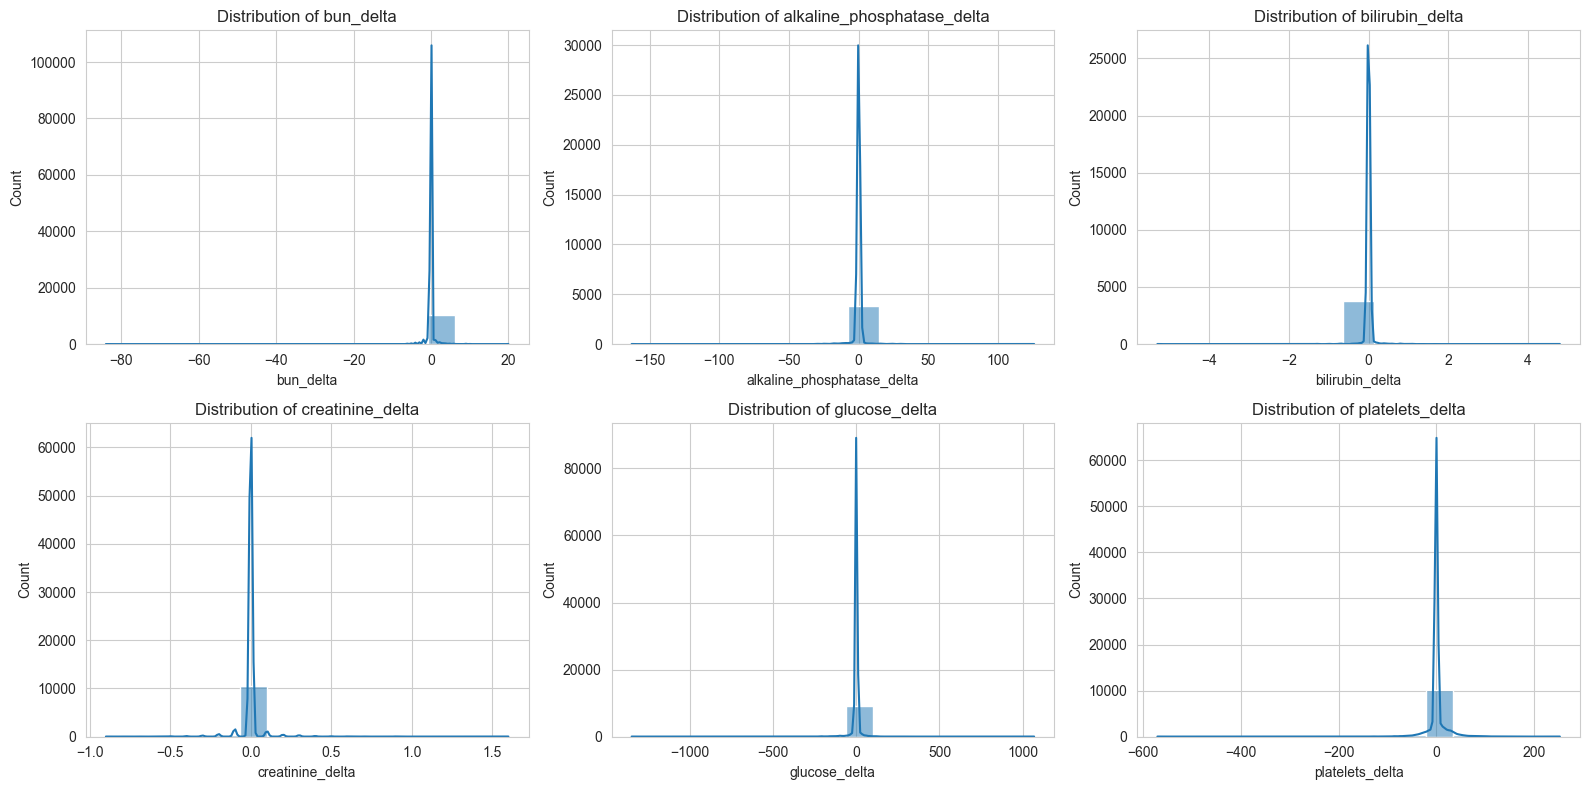

In [72]:
# Temporal analysis if time-based features exist
time_features = [col for col in df.columns if any(x in col.lower() for x in ['time', 'date', 'hour', 'day', 'month', 'year'])]

if time_features:
    print(f"Time-based features available: {time_features}")
    # Code to analyze temporal patterns would go here
else:
    print("No explicit time-based features available in the dataset")
    
# Look for delta features that represent changes over time
delta_features = [col for col in df.columns if 'delta' in col.lower()]
if delta_features:
    print(f"Found {len(delta_features)} delta features that represent changes over time:")
    print(delta_features[:10])
    
    # Analyze delta features - plot histograms of top ones
    plt.figure(figsize=(16, 8))
    for i, feature in enumerate(delta_features[:6]):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[feature].dropna(), kde=True)
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

In [73]:
# Final summary and insights
print("==== DESCRIPTIVE ANALYSIS SUMMARY ====")
print(f"Total patients analyzed: {len(df)}")
print(f"Total features analyzed: {len(df.columns)}")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print("\nMissingness:")
print(f"Features with >50% missing data: {sum(df.isnull().mean() > 0.5)}")
print(f"Features with <10% missing data: {sum(df.isnull().mean() < 0.1)}")

print("\nData Distribution:")
print("Highly skewed features (abs(skew) > 2):")
skewed_features = desc_stats[abs(desc_stats['skewness']) > 2].index.tolist()
print(skewed_features[:10])

print("\nCorrelation:")
print(f"Highly correlated feature pairs (|r| > 0.7): {len(corr_pairs)}")

if 'gender_numeric' in df.columns:
    gender_ratio = df['gender_numeric'].mean()
    print(f"\nGender ratio: {gender_ratio:.2f} (proportion male)")

print("\nKey clinical indicators with highest abnormal rates:")
if 'clinical_summary' in locals():
    abnormal_metrics = clinical_summary.sort_values('Within Normal Range (%)', ascending=True)
    for _, row in abnormal_metrics.head(5).iterrows():
        print(f"- {row['Metric']}: {100 - row['Within Normal Range (%)']:.1f}% abnormal")

# Suggest next steps for analysis
print("\nRecommended next steps:")
print("1. Address missing data with appropriate imputation strategies")
print("2. Transform skewed variables for modeling")
print("3. Consider dimensionality reduction using PCA findings")
print("4. Investigate outliers in key clinical measurements")
print("5. Explore relationships between clinical features and outcomes")

==== DESCRIPTIVE ANALYSIS SUMMARY ====
Total patients analyzed: 16922
Total features analyzed: 143
Numeric features: 132
Categorical features: 2

Missingness:
Features with >50% missing data: 16
Features with <10% missing data: 79

Data Distribution:
Highly skewed features (abs(skew) > 2):
['duration_hours', 'heart_rate_measured', 'resp_rate_measured', 'temp_min', 'temp_max', 'temp_measured', 'spo2_mean', 'spo2_min', 'spo2_max', 'spo2_measured']

Correlation:
Highly correlated feature pairs (|r| > 0.7): 100

Gender ratio: 0.55 (proportion male)

Key clinical indicators with highest abnormal rates:
- glucose_mean: 68.9% abnormal
- creatinine_mean: 62.1% abnormal
- sodium_mean: 52.5% abnormal
- potassium_mean: 52.1% abnormal
- dbp_mean: 51.0% abnormal

Recommended next steps:
1. Address missing data with appropriate imputation strategies
2. Transform skewed variables for modeling
3. Consider dimensionality reduction using PCA findings
4. Investigate outliers in key clinical measurements
